##Modelo BERT com função de perda ponderada e reamostragem (Dataset 70% para treinamento, 15% para teste e 15% para validação)

In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.4 MB/s eta 0:00:00


##Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "drive/MyDrive/Mestrado/defesa/data/70-15-15"
model_path = "drive/MyDrive/Mestrado/defesa/models"

Mounted at /content/drive


In [ ]:
dataset = load_dataset("csv", data_files={"train":data_path+'/comunic_treino_aug.csv', "test": data_path+'/comunic_teste.csv', "validation":data_path+'/comunic_valid.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c30bd544b75348fe/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

def preprocess_data(docs):
    text = docs["text"]
    return tokenizer(docs["text"], padding='max_length', max_length=512, truncation=True)

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True) #,remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/2932 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset.set_format("torch")

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=13)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [ ]:
batch_size = 16
metric_name = "f1"

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
    f"bert-finetuned-comunicados",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 5,
    learning_rate=1.362e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=30,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, hamming_loss
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}    

In [ ]:
from torch import nn
from transformers import Trainer

# the model is waiting for "labels", not "label"
encoded_dataset = encoded_dataset.rename_column("label", "labels")

# Get training encoded data into DataFrame
df = encoded_dataset["train"].to_pandas()

# Get a vector of weights (lowest weight for majority class)
class_weights = (1 - (df["labels"].value_counts().sort_index() / len(df))).values
print(class_weights)

# Put the weights vector to cuda as a Pytorch tensor
class_weights = torch.from_numpy(class_weights).float().to("cuda")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # define loss function with calss weights
        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        # Compute loss
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss


[0.93178718 0.93178718 0.93178718 0.93178718 0.81855389 0.93178718
 0.93178718 0.93178718 0.93178718 0.93178718 0.93178718 0.93178718
 0.93178718]


In [ ]:
trainer = CustomTrainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4)]
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2932
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5520
  Number of trainable parameters = 108933133


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.924138,0.814815,0.795319,0.814815,0.791260
2,No log,0.654362,0.843621,0.853430,0.843621,0.835787
3,0.972100,0.631166,0.851852,0.849096,0.851852,0.844372
4,0.972100,0.702715,0.855967,0.868617,0.855967,0.857213
5,0.972100,0.760703,0.868313,0.868846,0.868313,0.862277
6,0.075000,0.836950,0.860082,0.865936,0.860082,0.856887
7,0.075000,0.854055,0.864198,0.866487,0.864198,0.859258
8,0.075000,0.907046,0.868313,0.863740,0.868313,0.859873
9,0.012800,0.919531,0.868313,0.871070,0.868313,0.863865
10,0.012800,0.939029,0.872428,0.873810,0.872428,0.867204


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 243
  Batch size = 16
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-finetuned-comunicados/checkpoint-184
Configuration saved in bert-finetuned-comunicados/checkpoint-184/config.json
Model weights saved in bert-finetuned-comunicados/checkpoint-184/pytorch_model.bin
tokenizer config file saved in bert-finetuned-comunicados/checkpoint-184/tokenizer_config.json
Special tokens file saved in bert-finetuned-comuni

TrainOutput(global_step=2760, training_loss=0.19438151589770247, metrics={'train_runtime': 4258.1121, 'train_samples_per_second': 20.657, 'train_steps_per_second': 1.296, 'total_flos': 1.157276708112384e+16, 'train_loss': 0.19438151589770247, 'epoch': 15.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 243
  Batch size = 16


{'eval_loss': 0.9395723938941956,
 'eval_accuracy': 0.8806584362139918,
 'eval_precision': 0.880405257406612,
 'eval_recall': 0.8806584362139918,
 'eval_f1': 0.8748508565905666,
 'eval_runtime': 8.1639,
 'eval_samples_per_second': 29.765,
 'eval_steps_per_second': 1.96,
 'epoch': 15.0}

###Avaliação do modelo

In [ ]:
# Define test trainer
#test_trainer = Trainer(modelo_carregador) 
# Make prediction
#raw_pred, y_true, _ = test_trainer.predict(encoded_dataset['test']) 
# Preprocess raw predictions
#y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
y_pred, y_true, _ = trainer.predict(encoded_dataset['test']) #encoded_dataset['validation']
y_pred = np.argmax(y_pred, axis=1)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 243
  Batch size = 16


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.67      0.78      0.72        18
           2       0.75      1.00      0.86         3
           3       0.71      0.71      0.71         7
           4       0.95      0.97      0.96       114
           5       0.82      1.00      0.90         9
           6       1.00      0.75      0.86         4
           7       0.70      0.50      0.58        14
           8       0.50      1.00      0.67         4
           9       0.84      0.73      0.78        22
          10       0.83      0.71      0.77         7
          11       1.00      0.75      0.86         4
          12       0.95      0.82      0.88        22

    accuracy                           0.87       243
   macro avg       0.82      0.82      0.81       243
weighted avg       0.88      0.87      0.87       243



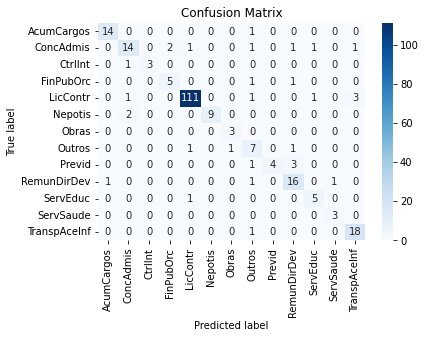

In [ ]:
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import tensorflow as tf
labels = ['AcumCargos', 'ConcAdmis', 'CtrlInt', 'FinPubOrc', 'LicContr', 'Nepotis', 'Obras', 'Outros', 'Previd', 'RemunDirDev', 'ServEduc', 'ServSaude', 'TranspAceInf']

def visualize_confusion_matrix(y_pred_argmax, y_true):
    cm = tf.math.confusion_matrix(y_pred_argmax, y_true).numpy()
    con_mat_df = pd.DataFrame(cm)
    #con_mat_df = con_mat_df.drop(columns=con_mat_df.columns[0])
    #con_mat_df = con_mat_df.drop(columns=con_mat_df.columns[3])
    #con_mat_df = con_mat_df.drop(labels=[0,4], axis=0)
    con_mat_df.columns = labels
    con_mat_df.set_axis(labels, axis='index', inplace=True)

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues)
    #plt.tight_layout()
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

visualize_confusion_matrix(y_pred, y_true)

In [ ]:
!pip install transformers_interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.8/793.8 KB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


In [ ]:
trainer.save_model(model_path+"/BERT_WL_balanced_70-15-15.mod")
from transformers import AutoModelForSequenceClassification
modelo_carregador = AutoModelForSequenceClassification.from_pretrained(model_path+"/BERT_WL_balanced_70-15-15.mod")
##trainer.save_model("Trained model")

Saving model checkpoint to drive/MyDrive/Mestrado/defesa/models/BERT_WL_balanced_70-15-15.mod
Configuration saved in drive/MyDrive/Mestrado/defesa/models/BERT_WL_balanced_70-15-15.mod/config.json
Model weights saved in drive/MyDrive/Mestrado/defesa/models/BERT_WL_balanced_70-15-15.mod/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/Mestrado/defesa/models/BERT_WL_balanced_70-15-15.mod/tokenizer_config.json
Special tokens file saved in drive/MyDrive/Mestrado/defesa/models/BERT_WL_balanced_70-15-15.mod/special_tokens_map.json
loading configuration file drive/MyDrive/Mestrado/defesa/models/BERT_WL_balanced_70-15-15.mod/config.json
Model config BertConfig {
  "_name_or_path": "drive/MyDrive/Mestrado/defesa/models/BERT_WL_balanced_70-15-15.mod",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,


In [ ]:
from transformers_interpret import SequenceClassificationExplainer
df=pd.DataFrame(dataset['test'])
df.iloc[19].text

'o denunciativo compareceu a esta ouvidoria para comunicar que a esposa do prefeito da cidade de prata tem a posse de um veiculo wv placa piw renavan que é de propriedade do pai do dono da empresa que presta serviço de transporte escolar e locação de um veiculo da marca toiota railux para prefeitura da cidade e que armazena prefeito armazena combustível no almoxarifado da prefeitura para abastecer os carros do transporte escolar no entendimento do denunciante os carros deveriam ser abastecidos pelo empresa contratada'

In [ ]:
comunic=pd.read_csv(data_path+'/comunic_teste.csv')
transp=comunic[comunic.label==1]
cls_explainer = SequenceClassificationExplainer(modelo_carregador, tokenizer)

for cada in transp["text"][:3].values:
    word_attributions = cls_explainer(cada)
    cls_explainer.visualize()
